In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical

Using TensorFlow backend.


from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline. These were obtained when recovering known objects in Pointing Group 010 to 089 in the Lori Allen NEO dataset

In [7]:
full_false = np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamp_training_set.npy')

### Make real dataset

Make some real Gaussians and add noise to use as truth for training. Add them to a background from real images and searched along a trajectory. Add some scatter in the alignment and some variance to the PSF size.

In [8]:
# import os
# from astropy.io import fits
# import matplotlib.dates as mdates
# import datetime as dt
# from dateutil.parser import parse
# import multiprocessing as mp
# import pickle

# with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
#     Pointing_Groups = pickle.load(f)

# # Import the times
# times=[[]]*len(Pointing_Groups)
# for i,pointing in enumerate(Pointing_Groups):
#     times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
#     for j in range(len(Pointing_Groups[i]['date_obs'])):
#         foo = parse(Pointing_Groups[i]['date_obs'][j])
#         times[i][j]= foo.timestamp()
        
# def makeSyntheticCoadd(pgccd):
#     """
#     This function generates a synthetic coadd for a given pointing group and ccd.
#     It generates a random trajectory along the visits and uses those to get 21x21
#     pixel stamps. It puts a gaussian with a semi-random PSF in each stamp, with
#     some scatter for the central pixel. It adds a linear offset to the stamps.
#     It then returns the median of all the stamps.
#     """
#     pg_num = pgccd[0]
#     ccd = pgccd[1]
#     visit_list = Pointing_Groups[pg_num]['visit_id']
#     cutout_size = 21 # pixels
#     speed_lims = [100,300] # px/day
#     ang_lims = [0,np.pi/2] # radians
#     time_baseline = (times[pg_num][-1]-times[pg_num][0])/(3600*24) # days
    
#     # Set a 2 pixel potential velocity offset
#     max_x_vel_offset = 4*(0.5-np.random.random())
#     max_y_vel_offset = 4*(0.5-np.random.random())
#     visit_num = len(visit_list)
    
#     if ccd==2 or ccd==61:
#         return([])
#     pg_object_list = []
#     for i,visit_id in enumerate(visit_list):
#         net_x_offset = (1-2*np.random.random())/2
#         net_y_offset = (1-2*np.random.random())/2
#         imagePath = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
#         diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
#         try:
#             hdul = fits.open(diffPath)
#         except:
#             continue
#         data = hdul[1].data
#         # Compute the values of various parameters for this specific stamp.
#         # Uses the limits defined above.
#         data_size = np.shape(data)
#         speed = (speed_lims[1]-speed_lims[0]) * np.random.random() + speed_lims[0]
#         angle = (ang_lims[1]-ang_lims[0]) * np.random.random() + ang_lims[0]
#         vel = [speed*np.cos(angle), speed*np.sin(angle)]
#         starting_pixel_xy_max = [data_size[1] - 100 - speed*time_baseline, data_size[0] - 100 - speed*time_baseline]
#         start_px = [50+starting_pixel_xy_max[0]*np.random.random(), 50+starting_pixel_xy_max[1]*np.random.random()]
#         min_gauss_sigma = 1
#         brightness_lims = [150,4000]
#         object_brightness = (brightness_lims[1]-brightness_lims[0])*np.random.random() + brightness_lims[0]
#         elapsed_time = (times[pg_num][i] - times[pg_num][0])/(3600*24)
#         pixel = [start_px[0]+vel[0]*elapsed_time, start_px[1]+vel[1]*elapsed_time]
#         min_x = int(pixel[0]-(cutout_size-1)/2)-1
#         max_x = int(pixel[0]+(cutout_size-1)/2)
#         min_y = int(pixel[1]-(cutout_size-1)/2)-1
#         max_y = int(pixel[1]+(cutout_size-1)/2)
#         cutout = np.copy(data[min_y:max_y,min_x:max_x])
#         cutout[np.isnan(cutout)] = 0
#         #cutout -= np.min(cutout)
#         #cutout /= np.sum(cutout)
#         cutout_edge = (cutout_size-1)/2                                                   
#         x = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         y = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         x, y = np.meshgrid(x, y)
#         sigma = np.random.random()+min_gauss_sigma
#         gaussian_kernel = (object_brightness * (1/(2*np.pi*sigma*sigma) 
#             * np.exp(-((x-net_x_offset-max_x_vel_offset*(i/visit_num))**2/(2*sigma**2) + (y-net_y_offset-max_y_vel_offset*(i/visit_num))**2/(2*sigma**2))))
#             * (1+(0.1*(np.random.random(cutout_size*cutout_size).reshape(cutout_size,cutout_size)-0.5)))) # add 3% noise to psf)
#         #sim_object = np.zeros((cutout_size, cutout_size))
#         #sim_object[int((cutout_size-1)/2), int((cutout_size-1)/2)] = object_brightness
#         #sim_object = gaussian_filter(sim_object, np.random.random()+min_gauss_sigma)
#         sim_object = cutout + gaussian_kernel
#         pg_object_list.append(sim_object)
#     if len(pg_object_list)>0:
#         median_coadd = np.median(pg_object_list, axis=0)
#     else:
#         median_coadd = []
#     return(median_coadd)

In [9]:
# # Generate the stamps using the above function.
# # This will take a while (approx. 2 hours)
# all_results = []
# pg_list = np.linspace(91,110,20).astype(int)
# foo = np.linspace(1,62,62).astype(int)
# foo = foo[foo!=2]
# ccd_list = foo[foo!=61]
# pgccd_list = []
# for pg in pg_list:
#     for ccd in ccd_list:
#         pgccd_list.append([pg,ccd])
# with mp.Pool(20) as pool:
#     for j in range(50):
#         results = pool.map(makeSyntheticCoadd, pgccd_list)
#         all_results.append(results)

In [10]:
# # Save the stamps
# all_coadd_stamps = np.concatenate(all_results, axis=0)
# np.save('stamps_simulated.npy', all_coadd_stamps)

In [11]:
full_true=np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamps_simulated_v3.npy')

## Train the CNN

In [12]:
## Will worry later about exact reproducibility
# import random as rn
# import tensorflow as tf

# np.random.seed(1519)
# rn.seed(97)


In [13]:
np.shape(full_false), np.shape(full_true)

((49978, 21, 21), (60000, 21, 21))

In [14]:
stamp_class = np.zeros(len(full_false) + len(full_true))
stamp_class[len(full_false):] = 1

In [15]:
input_stamps = np.vstack([full_false, full_true])

In [16]:
input_stamps.shape

(109978, 21, 21)

Shuffle data in a way we can reconstruct

In [17]:
rand_state = np.random.RandomState(32)
idx = rand_state.permutation(len(input_stamps))
input_stamps = input_stamps[idx]
stamp_class = stamp_class[idx]
stamp_class = to_categorical(stamp_class)

Use 70% of data for training, 20% for validation and 10% for test.

In [18]:
def normalize_data(in_data):

    in_data = in_data.reshape(len(in_data), 21*21)
    in_data -= np.min(in_data, axis=1).reshape(-1,1)
    in_data /= np.sum(in_data, axis=1).reshape(-1,1)
    in_data = in_data.reshape(len(in_data), 1, 21, 21)
    
    return in_data

In [19]:
train_len = np.int(0.7*len(stamp_class))
val_len = np.int(0.2*len(stamp_class))
test_len = len(stamp_class) - train_len - val_len

train_data = input_stamps[:train_len]
train_data = normalize_data(train_data)
train_class = stamp_class[:train_len]
val_data = input_stamps[train_len:train_len+val_len]
val_data = normalize_data(val_data)
val_class = stamp_class[train_len:train_len+val_len]
test_data = input_stamps[train_len+val_len:]
test_data = normalize_data(test_data)
test_class = stamp_class[train_len+val_len:]

In [20]:
train_len, val_len, test_len, len(stamp_class)

(76984, 21995, 10999, 109978)

In [21]:
len(train_data), len(val_data), len(test_data), len(stamp_class)

(76984, 21995, 10999, 109978)

In [22]:
np.shape(train_data), len(val_data), len(test_data), len(stamp_class)

((76984, 1, 21, 21), 21995, 10999, 109978)

In [23]:
model = Sequential()

batch_size = 128

model.add(Conv2D(batch_size, (3, 3), padding='same', activation='relu',
                 input_shape=(1, 21,21)))
model.add(Conv2D(batch_size, (3, 3), activation='relu', padding='same', ))
model.add(Flatten())
model.add(Dense(units=2, activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [25]:
n_epochs = 250
model_history = model.fit(train_data, train_class, epochs=n_epochs, batch_size=128, verbose=1, validation_data=(val_data, val_class), shuffle=True)


Train on 76984 samples, validate on 21995 samples
Epoch 1/250
76984/76984 [==============================] - 14s 184us/step - loss: 0.6892 - accuracy: 0.5439 - val_loss: 0.6883 - val_accuracy: 0.5472
Epoch 2/250
76984/76984 [==============================] - 8s 106us/step - loss: 0.6888 - accuracy: 0.5445 - val_loss: 0.6882 - val_accuracy: 0.5472
Epoch 3/250
76984/76984 [==============================] - 7s 92us/step - loss: 0.6887 - accuracy: 0.5445 - val_loss: 0.6881 - val_accuracy: 0.5472
Epoch 4/250
76984/76984 [==============================] - 8s 108us/step - loss: 0.6886 - accuracy: 0.5445 - val_loss: 0.6881 - val_accuracy: 0.5472
Epoch 5/250
76984/76984 [==============================] - 8s 102us/step - loss: 0.6885 - accuracy: 0.5445 - val_loss: 0.6879 - val_accuracy: 0.5472
Epoch 6/250
76984/76984 [==============================] - 8s 102us/step - loss: 0.6883 - accuracy: 0.5445 - val_loss: 0.6878 - val_accuracy: 0.5472
Epoch 7/250
76984/76984 [==============================

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

Text(0, 0.5, 'Loss')

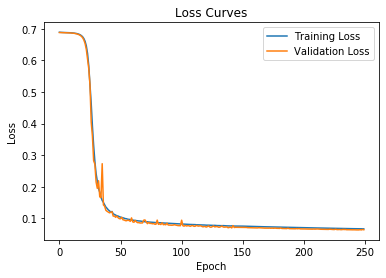

In [27]:
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

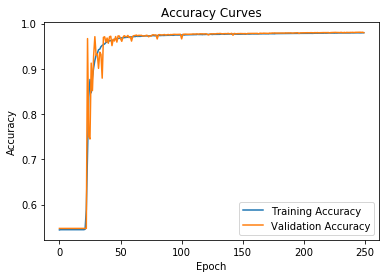

In [28]:
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Run prediction on test data

In [29]:
classes = model.predict(test_data)

Text(0, 0.5, 'Stamp Counts')

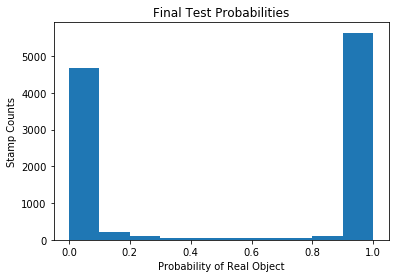

In [30]:
plt.hist(classes[:,1])
plt.title('Final Test Probabilities')
plt.xlabel('Probability of Real Object')
plt.ylabel('Stamp Counts')

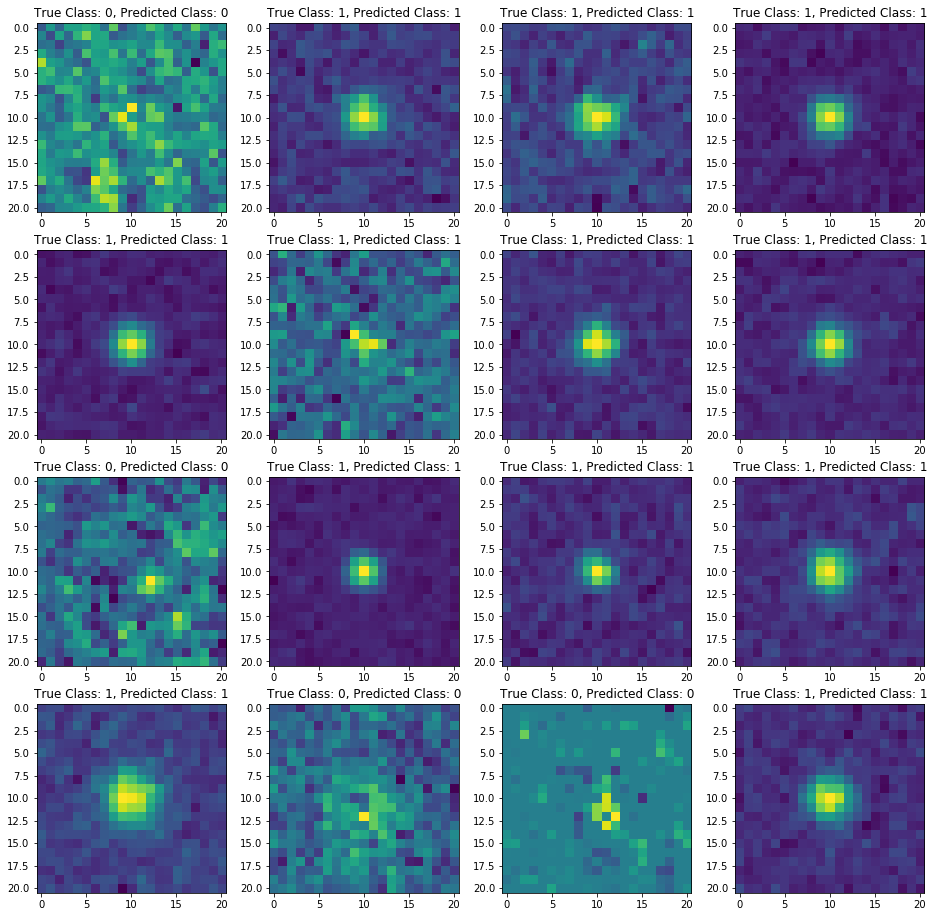

In [31]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(test_data[i].reshape(21,21))
    plt.title('True Class: %i, Predicted Class: %i' % (np.argmax(test_class[i]), np.argmax(classes[i])))

In [32]:
fpr = []
tpr = []
for cutoff in np.arange(0.01, 1.0, 0.01):
    correct_false = []
    correct_true = []
    false_positive = []
    false_negative = []
    index = 0
    for true_class, result_prob in zip(test_class, classes):
        if np.argmax(true_class) == 0.:
            if result_prob[1] < cutoff:
                correct_false.append(index)
            else:
                false_positive.append(index)
        else:
            if result_prob[1] < cutoff:
                false_negative.append(index)
            else:
                correct_true.append(index)
        index+=1
    fpr.append(len(false_positive)/len(np.where(test_class[:,1] == 0)[0]))
    tpr.append(len(correct_true)/len(np.where(test_class[:,1] == 1)[0]))

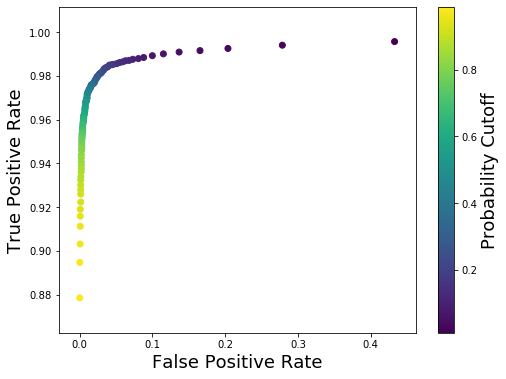

In [33]:
fig = plt.figure(figsize=(8,6))
plt.scatter(fpr, tpr, c=np.arange(0.01, 1.0, 0.01))
cbar = plt.colorbar()
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
cbar.set_label('Probability Cutoff', size=18)

In [34]:
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.5
for true_class, result_prob in zip(test_class, classes):
    if np.argmax(true_class) == 0.:
        if result_prob[1] < cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob[1] < cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1

In [35]:
keras_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])

In [36]:
len(false_positive)

47

(2, 0)

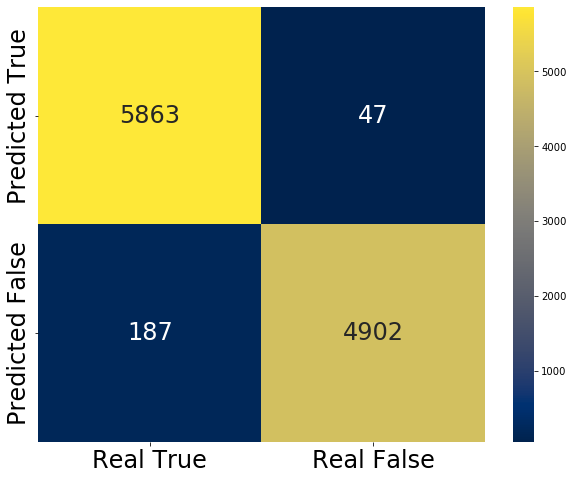

In [37]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(keras_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')
plt.ylim(2, 0)

### Look at False Negatives and False Positives

/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


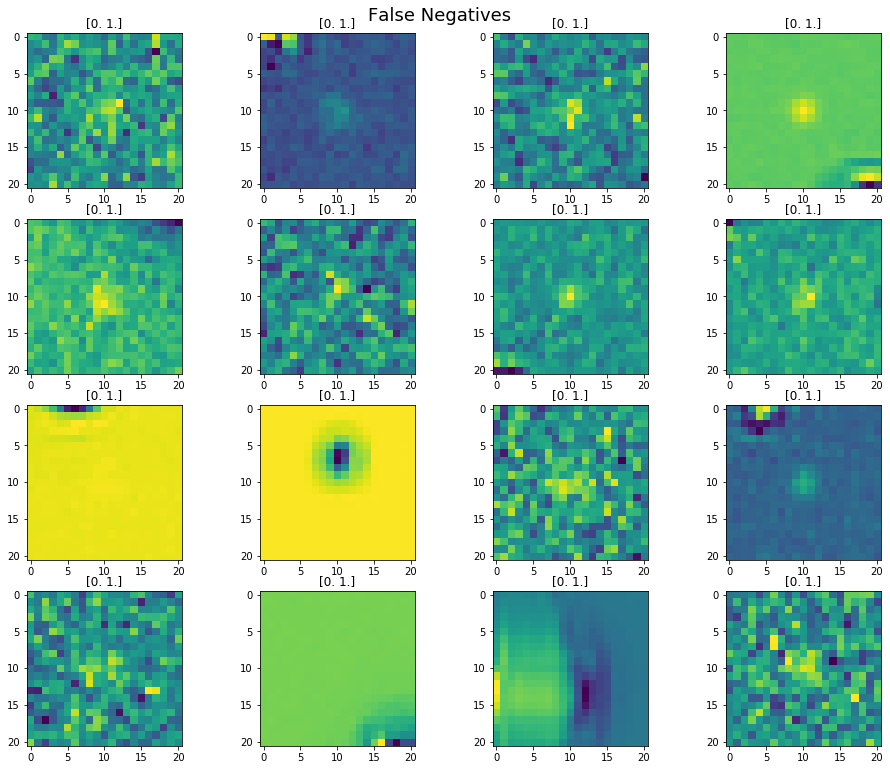

In [38]:
fig = plt.figure(figsize=(16, 12))
for i in range(16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_negative[i]].reshape(21,21))
        plt.title(test_class[false_negative[i]])
    except:
        continue
plt.suptitle('False Negatives', size=18)
plt.subplots_adjust(top=0.95)

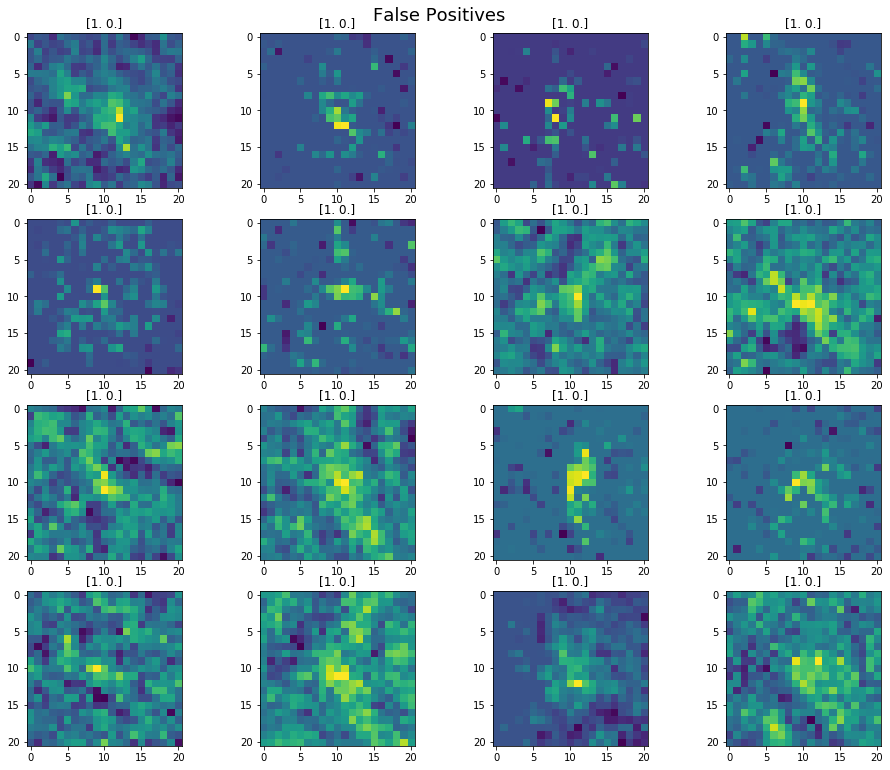

In [39]:
fig = plt.figure(figsize=(16, 12))
for i in range(16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_positive[i]].reshape(21,21))
        plt.title(test_class[false_positive[i]])
    except:
        continue
plt.suptitle('False Positives', size=18)
plt.subplots_adjust(top=0.95)

## Save Model

In [40]:
filename = 'keras_kbmod.h5'
model.save(filename)